## 7.2 Distinguishing birds from airplanes


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [4]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [5]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

### 7.2.1 Building the dataset


t! Well, why not take a shortcut and just filter the
data in cifar10 and remap the labels so they are contiguous? Here’s how

In [6]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10 
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

 We have a dataset! Next, we need a model to feed our data to. 


### 7.2.2 A fully connected model


In [7]:
import torch.nn as nn

n_out = 2

model = nn.Sequential(
            nn.Linear(
                3072,  # <1> input layer 32*32*3
                512,   # <2> hidden layer v
            ),
            nn.Tanh(),
            nn.Linear(
                512,   # <2> hidden layer ^
                n_out, # <3> output layer
            )
        )

### 7.2.3 Output of a classifier


t. We could do something similar here: make our network output a single scalar value (so n_out = 1), cast the labels to floats (0.0 for airplane and 1.0 for bird), and use those as a target for MSELoss (the average of squared
differences in the batch).

As we learned in
chapter 4, when we have to represent a categorical variable, we should switch to a
one-hot-encoding representation of that variable, such as [1, 0] for airplane or [0, 1] <br>for bird (the order is arbitrary). This will still work if we have 10 classes, as in the full
CIFAR-10 dataset; we’ll just have a vector of length 10

It sounds like a tough constraint to enforce in a differentiable way on a vector of numbers. Yet there’s a very smart trick that does exactly that, and it’s differentiable: it’s
called softmax. 

### 7.2.4 Representing the output as probabilities


That is, we take the elements of the vector, compute the elementwise exponential,
and divide each element by the sum of exponentials. In code, it’s something like this

In [8]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [9]:
x = torch.tensor([1.0, 2.0, 3.0])

softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [10]:
softmax(x).sum()

tensor(1.)

nn.Softmax requires us to specify
the dimension along which the softmax function is applied:

In [11]:
softmax = nn.Softmax(dim=1)

x = torch.tensor([[1.0, 2.0, 3.0],
                  [1.0, 2.0, 3.0]])

softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

Excellent! We can now add a softmax at the end of our model, and our network
will be equipped to produce probabilities:

In [12]:
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.Softmax(dim=1))

We can actually try running the model before even training it. Let’s do it, just to see
what comes out. We first build a batch of one image, our bird

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


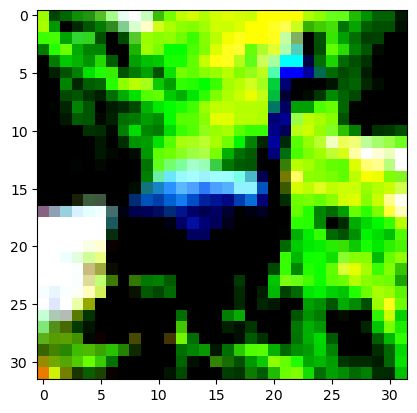

In [13]:
img, _ = cifar2[0]
plt.imshow(img.permute(1, 2, 0))
plt.show()

So we need to turn our 3 × 32 × 32 image into a 1D tensor and then add an extra dimension in the zeroth position

In [14]:
img_batch = img.view(-1).unsqueeze(0) 

In [15]:
out = model(img_batch)
out

tensor([[0.4784, 0.5216]], grad_fn=<SoftmaxBackward0>)

In [16]:
_, index = torch.max(out, dim=1)
index

tensor([1])

Time to get
training. As in the previous two chapters, we need a loss to minimize during training.

### 7.2.5 A loss for classifying


In other words, we want to penalize misclassifications rather than painstakingly penalize everything that doesn’t look exactly like a 0.0 or 1.0

 What we need to maximize in this case is the probability associated with the correct
class, out[class_index], where out is the output of softmax and class_index is a vector containing 0 for “airplane” and 1 for “bird” for each sample. 

and it’s called negative log likelihood
(NLL). It has the expression NLL = - sum(log(out_i[c_i])), where the sum is taken
over N samples and c_i is the correct class for sample i

#### Summing up, our loss for classification can be computed as follows. For each sample in the batch:
1 Run the forward pass, and obtain the output values from the last (linear) layer.<br>
2 Compute their softmax, and obtain probabilities.<br>
3 Take the predicted probability corresponding to the correct class (the likelihood of the parameters). Note that we know what the correct class is because
it’s a supervised problem—it’s our ground truth.<br>
4 Compute its logarithm, slap a minus sign in front of it, and add it to the loss.


 use nn.LogSoftmax instead of nn.Softmax, which takes care to make
the calculation numerically stable

In [17]:
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

In [18]:
loss = nn.NLLLoss()


In [54]:
img, label = cifar2[0]
out = model(img.view(-1).unsqueeze(0))
loss(out, torch.tensor([label]))

tensor(0.7255, grad_fn=<NllLossBackward0>)

### 7.2.6 Training the classifier


We’re ready to bring back the training loop we wrote in chapter 5 and see
how it trains

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 50

for epoch in range(n_epochs):
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

## cant run this on laptop, but CAN WITH BATCHING VV DOWN VV

 Typically, minibatches are a constant size that we need to set prior to training, just
like the learning rate. These are called hyperparameters, to distinguish them from the
parameters of a model.

In our training code, we chose minibatches of size 1 by picking one item at a time from
the dataset. The torch.utils.data module has a class that helps with shuffling and
organizing the data in minibatches: DataLoader.

In [19]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

A DataLoader can be iterated over, so we can use it directly in the inner loop of our
new training code:

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 128),
            nn.Tanh(),
            nn.Linear(128, 2),
            nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.309770
Epoch: 1, Loss: 0.401999
Epoch: 2, Loss: 0.774094
Epoch: 3, Loss: 0.482962
Epoch: 4, Loss: 0.569812
Epoch: 5, Loss: 0.574610
Epoch: 6, Loss: 0.285785
Epoch: 7, Loss: 0.410845
Epoch: 8, Loss: 0.403018
Epoch: 9, Loss: 0.307971
Epoch: 10, Loss: 0.423347
Epoch: 11, Loss: 0.272704
Epoch: 12, Loss: 0.174574
Epoch: 13, Loss: 0.261563
Epoch: 14, Loss: 0.171392
Epoch: 15, Loss: 0.311833
Epoch: 16, Loss: 0.305926
Epoch: 17, Loss: 0.121198
Epoch: 18, Loss: 0.242821
Epoch: 19, Loss: 0.276443
Epoch: 20, Loss: 0.229399
Epoch: 21, Loss: 0.485213
Epoch: 22, Loss: 0.099340
Epoch: 23, Loss: 0.355324
Epoch: 24, Loss: 0.127063
Epoch: 25, Loss: 0.313473
Epoch: 26, Loss: 0.163736
Epoch: 27, Loss: 0.138536
Epoch: 28, Loss: 0.202282
Epoch: 29, Loss: 0.189369
Epoch: 30, Loss: 0.102208
Epoch: 31, Loss: 0.083752
Epoch: 32, Loss: 0.144667
Epoch: 33, Loss: 0.077734
Epoch: 34, Loss: 0.270563
Epoch: 35, Loss: 0.140062
Epoch: 36, Loss: 0.424655
Epoch: 37, Loss: 0.187342
Epoch: 38, Loss: 0.092

At each inner iteration, imgs is a tensor of size 64 × 3 × 32 × 32—that is, a minibatch of
64 (32 × 32) RGB images—while labels is a tensor of size 64 containing label indices

In [22]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.809500


We can certainly add some bling to our model by including more layers, which will
increase the model’s depth and capacity. One rather arbitrary possibility is

In [23]:
model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2),
    nn.LogSoftmax(dim=1))

 It is quite common to drop the last nn.LogSoftmax layer from the network and use
nn.CrossEntropyLoss as a loss. Let us try that

In [24]:
model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

loss_fn = nn.CrossEntropyLoss()

Note that the numbers will be exactly the same as with nn.LogSoftmax and nn.NLLLoss.
It’s just more convenient to do it all in one pass, with the only gotcha being that the output of our model will not be interpretable as probabilities (or log probabilities). We’ll
need to explicitly pass the output through a softmax to obtain those.


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 30#SHOULD BE 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.655991
Epoch: 1, Loss: 0.519296
Epoch: 2, Loss: 0.582318
Epoch: 3, Loss: 0.347640
Epoch: 4, Loss: 0.333794
Epoch: 5, Loss: 0.453354
Epoch: 6, Loss: 0.421042
Epoch: 7, Loss: 0.467150
Epoch: 8, Loss: 0.462818
Epoch: 9, Loss: 0.272433
Epoch: 10, Loss: 0.379159
Epoch: 11, Loss: 0.414412
Epoch: 12, Loss: 0.505951
Epoch: 13, Loss: 0.298752
Epoch: 14, Loss: 0.263529
Epoch: 15, Loss: 0.356218
Epoch: 16, Loss: 0.350260
Epoch: 17, Loss: 0.128370
Epoch: 18, Loss: 0.918424
Epoch: 19, Loss: 0.169709
Epoch: 20, Loss: 0.290795
Epoch: 21, Loss: 0.206082
Epoch: 22, Loss: 0.344824
Epoch: 23, Loss: 0.158654
Epoch: 24, Loss: 0.298542
Epoch: 25, Loss: 0.266317
Epoch: 26, Loss: 0.250415
Epoch: 27, Loss: 0.058011
Epoch: 28, Loss: 0.456119
Epoch: 29, Loss: 0.108565


## RAN ONLY 30/100 EPOCHS OF ABOVE CODE SINCE ITS SLOW ON LAPTOP

#### accuracy on validation is 80% but on training is 99%, we are overfitting

To find out how many elements are in each tensor
instance, we can call the numel method. Summing those gives us our total count.
Depending on our use case, counting parameters might require us to check whether a
parameter has requires_grad set to True, as well. We might want to differentiate the
number of trainable parameters from the overall model size. Let’s take a look at what
we have right now

In [31]:
sum([p.numel() for p in model.parameters()])


3737474

In [32]:
linear = nn.Linear(3072, 1024)
linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

What is this telling us? That our neural network won’t scale very well with the number
of pixels. What if we had a 1,024 × 1,024 RGB image? That’s 3.1 million input values.
Even abruptly going to 1,024 hidden features (which is not going to work for our classifier), we would have over 3 billion parameters. Using 32-bit floats, we’re already at 12
GB of RAM, and we haven’t even hit the second layer, much less computed and stored
the gradients. That’s just not going to fit on most present-day GPUs.

### 7.2.7 The limits of going fully connected + conclusion
In more
technical terms, a fully connected network is not translation invariant

 This means a
network that has been trained to recognize a Spitfire starting at position 4,4 will not
be able to recognize the exact same Spitfire starting at position 8,8

 So, at the end of this chapter, we have a dataset, a model, and a training loop, and
our model learns. However, due to a mismatch between our problem and our network
structure, we end up overfitting our training data, rather than learning the generalized features of what we want the model to detect

so we’re forced to
use a lot of capacity for learning translated replicas if we want to hope to do well on
the validation set. There has to be a better way, right?
 Of course, most such questions in a book like this are rhetorical. The solution to
our current set of problems is to change our model to use convolutional layers. We’ll
cover what that means in the next chapter. 

We’ve also found a severe shortcoming of our model: we have been treating 2D
images as 1D data. Also, we do not have a natural way to incorporate the translation
invariance of our problem. 

ture of image data to get much better results.9
 We could use what we have learned right away to process data without this translation
invariance. For example, using it on tabular data or the time-series data we met in chapter 4, we can probably do great things already. To some extent, it would also be possible
to use it on text data that is appropriately represented.
